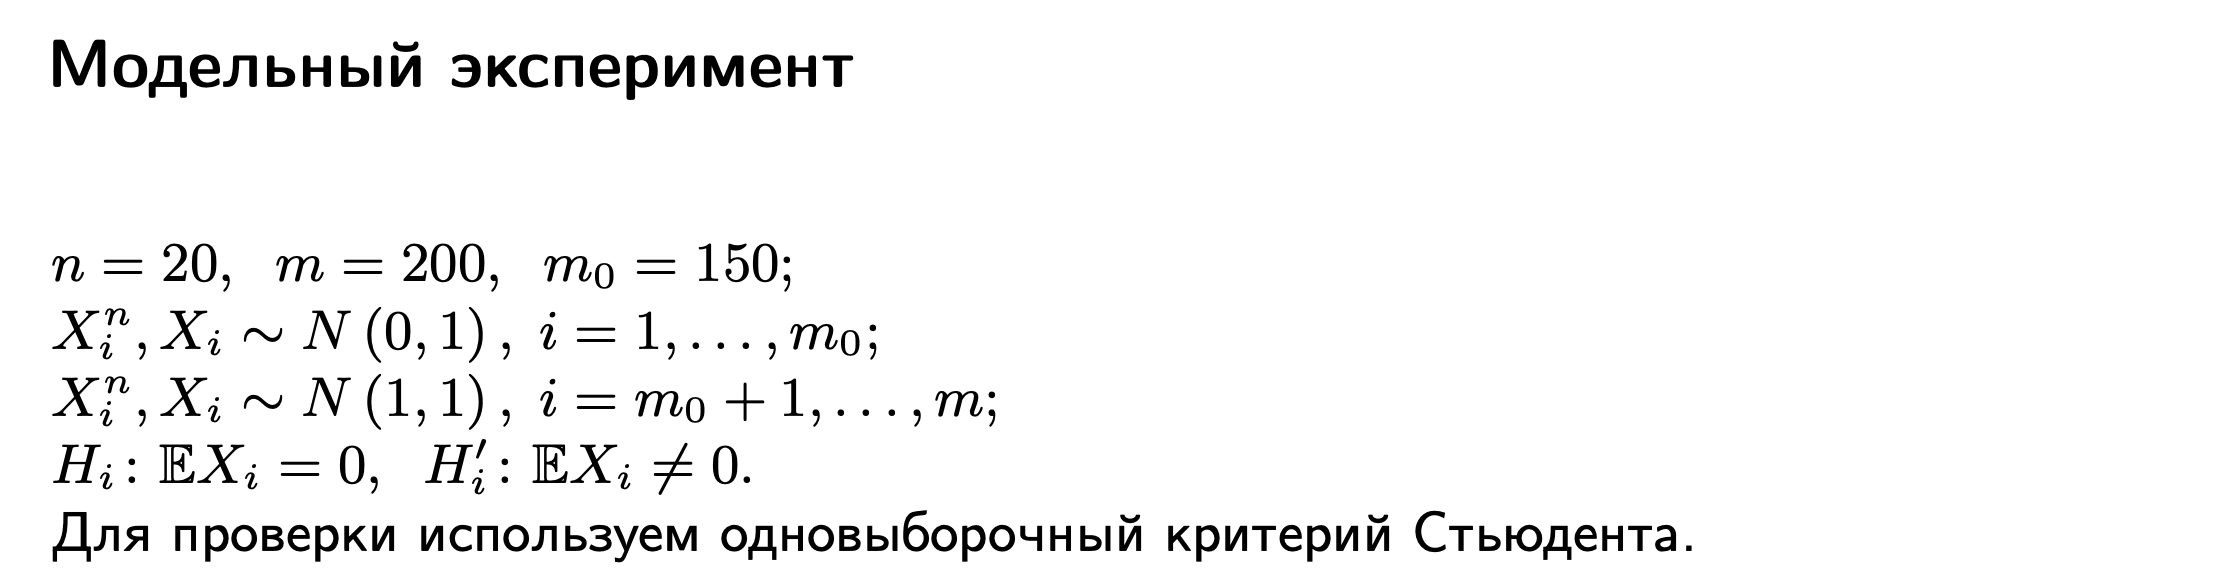

Положим параметр $m \in [200, 100000]$.

In [1]:
import numpy as np
import scipy.stats as st
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(43)
n = 20
m0 = 150

In [3]:
def get_samples(m):
    assert m > m0
    samples_1 = np.random.normal(0, 1, size=(m0, n))
    samples_2 = np.random.normal(1, 1, size=(m-m0, n))
    samples = np.concatenate([samples_1, samples_2], axis=0)
    return samples

    
def confusion_stats(rejs):
    #confusion matrix
    tn = m0 - rejs[:m0].sum()
    fp = rejs[:m0].sum()
    fn = m-m0 - rejs[m0:].sum()
    tp = rejs[m0:].sum()
    return tn, fp, fn, tp


def get_fdr(rejs):
    #false discovery rate
    tn, fp, fn, tp = confusion_stats(rejs)
    fdr = fp / (tp + fp)
    return fdr

In [4]:
up_bound = 100000
power = np.ceil(np.log2(up_bound/200)+1).astype(int)
grid = [200*2**i for i in range(power)]
grid[-1] = up_bound

In [5]:
fdrs = np.zeros((3, power))

In [6]:
for i, m in enumerate(grid):
    # sample data
    samples = get_samples(m)
    # compute Student test
    _, pvals = st.ttest_1samp(samples, np.zeros(m), axis=1)
    # no correction
    rejs = pvals < 0.05
    fdrs[0, i] = get_fdr(rejs)
    # benjamini-hochberg
    rejs = multipletests(pvals, alpha=0.05, method='fdr_bh')[0]
    fdrs[1, i] = get_fdr(rejs)
    # bonferroni
    rejs = multipletests(pvals, alpha=0.05, method='bonferroni')[0]
    fdrs[2, i] = get_fdr(rejs)

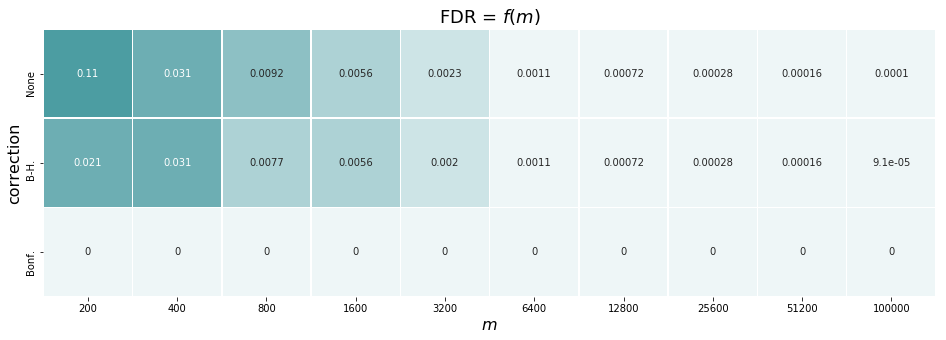

In [16]:
cmap = sns.light_palette((200, 75, 60), input="husl", reverse=True)
plt.figure(figsize=(16, 10))
annot = fdrs
smooth_fdrs = 1/(fdrs+0.01) # hack to ignore outliers in color palette, while annotation is real fdrs
sns.heatmap(smooth_fdrs, cmap=cmap, annot=fdrs, square=True, linewidths=.5, cbar=False,\
            yticklabels=['None', 'B-H.', 'Bonf.'], xticklabels=grid)
plt.title('FDR = $f(m)$', fontsize=18)
plt.xlabel('$m$', fontsize=16)
plt.ylabel('correction', fontsize=16);

---
---
Подводя черту, можем утвержать, что при множественной проверке гипотез на практике рассматроенные методы позволяют ограничивать значение FDR на желаемом уровне (в отличие от метода, не подразумевающего каких-либо поправок), более того, FDR убывает с ростом $m$.

В случае поправке Бонферрони во всех экспериментах не было совершено ни одной ошибки первого рода, впрочем, как было показано в лекции, это достигается ценой падения шанса отклонить неверные гипотезы. Из этого следует, что при увеличении $m$ в результате применения поправки Бонферрони мощность статистической процедуры резко уменьшается, что в общем случае делает нецелесообразным ее применение.

Поправка Бенджамини-Хохберга также контролирует FDR на заданном уровне $\alpha$, поскольку выполнено ограничение применимости поправки, а именно $T_i$ независимы. Таким образом, поправка корректна для данной задачи и более желательна к применению в силу меньшей радикальности.